In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in data
df = pd.read_csv('data/training_data.csv', index_col=0)

In [3]:
#looking at target variable
df.Y.value_counts()

0                             17471
1                              5028
default payment next month        1
Name: Y, dtype: int64

In [4]:
#renaming the columns
columns = df.loc['ID'].values #I'll be saving these column names for the test set

df.columns = columns 

#dropping that row
df.drop(['ID'], inplace = True)

In [5]:
#renaming the target value 
df = df.rename(columns = {'default payment next month': 'DEFAULT'})

In [6]:
df.dtypes.head(2)

LIMIT_BAL    object
SEX          object
dtype: object

In [7]:
#renaming the other columns based on their descriptions:
df = df.rename(columns = {'PAY_0':'PAYSTATUS_SEP','PAY_2':'PAYSTATUS_AUG', 'PAY_3':'PAYSTATUS_JUL', 'PAY_4':'PAYSTATUS_JUN', 'PAY_5':'PAYSTATUS_MAY', 'PAY_6':'PAYSTATUS_APR',
                         'BILL_AMT1':'BILLAMT_SEP', 'BILL_AMT2':'BILLAMT_AUG','BILL_AMT3':'BILLAMT_JUL', 'BILL_AMT4':'BILLAMT_JUN', 'BILL_AMT5':'BILLAMT_MAY', 'BILL_AMT6':'BILLAMT_APR',
                         'PAY_AMT1': 'PAYAMT_SEP', 'PAY_AMT2': 'PAYAMT_AUG', 'PAY_AMT3': 'PAYAMT_JUL', 'PAY_AMT4': 'PAYAMT_JUN', 'PAY_AMT5': 'PAYAMT_MAY', 'PAY_AMT6': 'PAYAMT_APR' })

#converting columns to their appropriate dtypes
df = df.astype({'LIMIT_BAL': np.float32 , 'BILLAMT_SEP':np.float32, 'BILLAMT_AUG':np.float32, 'BILLAMT_JUL':np.float32, 'BILLAMT_JUN':np.float32,
                'BILLAMT_MAY':np.float32, 'BILLAMT_APR':np.float32, 'PAYAMT_SEP':np.float32, 'PAYAMT_AUG':np.float32, 
               'PAYAMT_JUL':np.float32, 'PAYAMT_JUN':np.float32, 'PAYAMT_MAY':np.float32, 'PAYAMT_APR':np.float32})

In [8]:
df.dtypes.head()

LIMIT_BAL    float32
SEX           object
EDUCATION     object
MARRIAGE      object
AGE           object
dtype: object

Before I start cleaning I am going to evaluate the target variable.

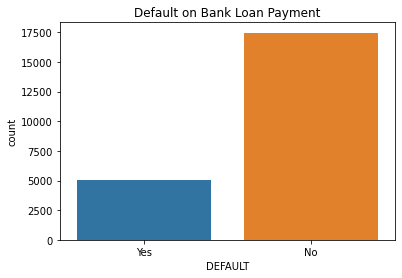

In [9]:
fig, ax = plt.subplots()
sns.countplot(df['DEFAULT'])
ax.set_title('Default on Bank Loan Payment')
ax.set_xticklabels(['Yes', 'No']);

In [10]:
print(df[df['DEFAULT'] == '1'].shape[0] / df.shape[0])

0.22347659895995378


The dataset is imbalanced. The majority of the people do not default on their payments. There is approximately an 80/20% imbalance in the dataset in favor of NONDEFAULTERS. I am going to set my class_weight parameter to 'balanced' to try to make a more even playing field. For now, I am going to clean the data as is so no major cleaning changes would be affected.

*SEX*

In [11]:
df.SEX.value_counts(normalize = True)

2    0.603227
1    0.396773
Name: SEX, dtype: float64

In [12]:
#changing the values to 1 and 0 
df['SEX'] = np.where(df['SEX'] == '1', 1, 0)

There are no strange values in this column. It is worth noting that the sample proportions of men to women are a little **imbalanced**. I changed the values here because I plan to use interaction features with this variable.

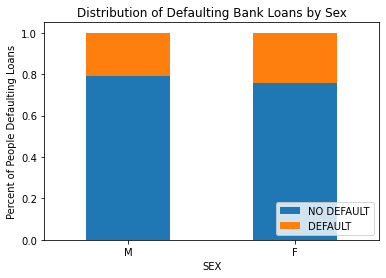

In [13]:
fig, ax = plt.subplots()
df.groupby('SEX')['DEFAULT'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('Percent of People Defaulting Loans')
ax.set_title('Distribution of Defaulting Bank Loans by Sex')
ax.set_xticklabels(['M', 'F'], rotation = 360);
ax.legend(loc='lower right', labels=['NO DEFAULT', 'DEFAULT']);


There doesn't seem to be a large difference of defaults between Males and Females.

*EDUCATION*

In [14]:
df.EDUCATION.value_counts()

2    10516
1     7919
3     3713
5      208
4       90
6       42
0       11
Name: EDUCATION, dtype: int64

Given that 5, 6, and 0 are not actual values, I have decided to impute them with the mode because these are categorical variables.

In [15]:
#imputing the EDU column
conditions = [df['EDUCATION'] == '1',df['EDUCATION'] =='2',df['EDUCATION'] =='3',df['EDUCATION'] =='4']
choices = [1,2,3,4]
df['EDUCATION'] = np.select(conditions, choices, default = 2)

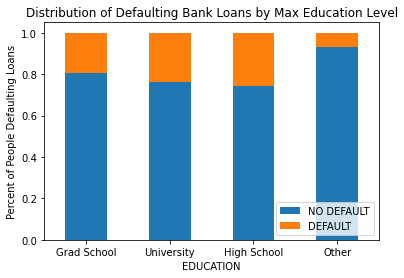

In [16]:
education_levels = ['Grad School', 'University', 'High School', 'Other']

fig, ax = plt.subplots()
df.groupby('EDUCATION')['DEFAULT'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('Percent of People Defaulting Loans')
ax.set_title('Distribution of Defaulting Bank Loans by Max Education Level')
ax.set_xticklabels(education_levels, rotation = 360);
ax.legend(loc='lower right', labels=['NO DEFAULT', 'DEFAULT']);

It looks like people with High School as their Maximum Education Level are more likely to default their bank loans.

*MARRIAGE*

In [17]:
df.MARRIAGE.value_counts()

2    12026
1    10195
3      234
0       44
Name: MARRIAGE, dtype: int64

There is a 0 value. It is undefined in the documentation. So, again I will imput the mode because these are categorical variables.

In [18]:
df['MARRIAGE'] = np.where(df['MARRIAGE'] == '0', '2', df['MARRIAGE'])

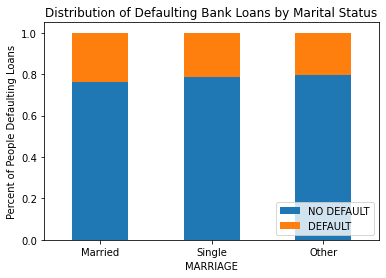

In [19]:
marriage = ['Married', 'Single', 'Other']

fig, ax = plt.subplots()
df.groupby('MARRIAGE')['DEFAULT'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('Percent of People Defaulting Loans')
ax.set_title('Distribution of Defaulting Bank Loans by Marital Status')
ax.set_xticklabels(marriage, rotation = 360);
ax.legend(loc='lower right', labels=['NO DEFAULT', 'DEFAULT']);

The percent of people -grouped by martial status- defaulting on their bank loans is about equal.

*AGE*

In [20]:
#Checking the age range and distribution of ages
int(df['AGE'].max()) - int(df['AGE'].min())

54

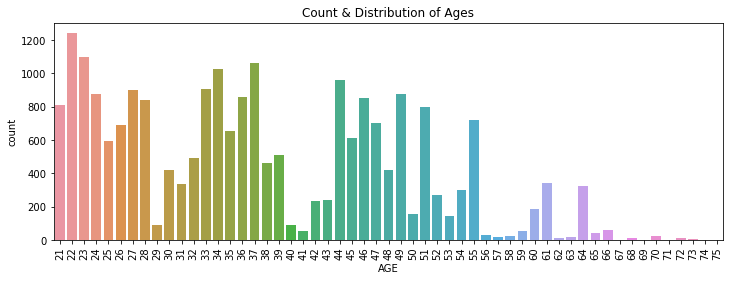

In [21]:
fig, ax = plt.subplots(figsize = (12, 4))
sns.countplot(df['AGE'])
ax.set_title('Count & Distribution of Ages')
ax.set_xticklabels(sorted(df['AGE'].unique()), rotation = 90);

In [22]:
#converting age to int for easier iteration
df['AGE'] = df['AGE'].astype('int')

#create a function to get age groups
def age_groups(x):
    if x in range(20, 30):
        return '2'
    elif x in range(30, 40):
        return '3'
    else:
        return '4'

In [23]:
df['AGE_GROUPS'] = df['AGE'].apply(lambda x: age_groups(x))

In [24]:
df['AGE_GROUPS'].value_counts()

3    8414
2    7287
4    6798
Name: AGE_GROUPS, dtype: int64

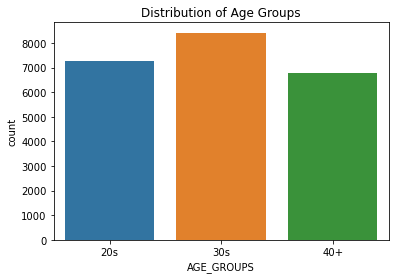

In [25]:
fig, ax = plt.subplots()
sns.countplot(df['AGE_GROUPS'], order = ['2', '3', '4'])
ax.set_xticklabels(['20s', '30s', '40+'])
ax.set_title('Distribution of Age Groups');

With this grouping, the distribution of ages is more symmetrical.

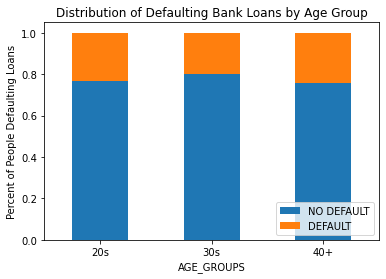

In [26]:
age_levels = ['20s', '30s', '40+']

fig, ax = plt.subplots()
df.groupby('AGE_GROUPS')['DEFAULT'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax)
ax.set_ylabel('Percent of People Defaulting Loans')
ax.set_title('Distribution of Defaulting Bank Loans by Age Group')
ax.set_xticklabels(age_levels, rotation = 360);
ax.legend(loc='lower right', labels=['NO DEFAULT', 'DEFAULT']);

From here we can see the group least likely to DEFAULT is the 30s group.

Before I continue, I am going to make sure we only have 1 AGE column and that it is the grouped one.

In [27]:
#renaming the AGE_GROUP column to replace the original
df['AGE'] = df['AGE_GROUPS']

#deleting the group column
df.drop('AGE_GROUPS', axis = 1, inplace = True)

*PAYSTATUS Variables*

First, -2 is not a defined value in the documentation. I am going to impute all of those with the mode, 0 because these are categorical variables.

In [28]:
#making a list of columns
paystats = list(df.columns[5:11])

In [29]:
def impute(cols):
    for i in cols:
        df[i]=np.where(df[i]=='-2','0',df[i])
    return df

In [30]:
df = impute(paystats)

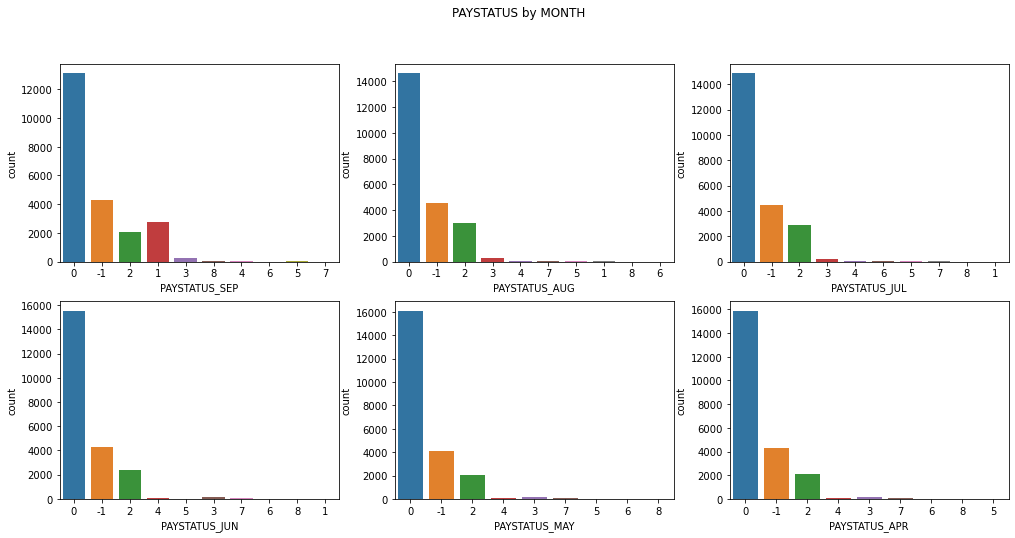

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(17,8))
plt.suptitle('PAYSTATUS by MONTH')
sns.countplot(df['PAYSTATUS_SEP'], ax = ax[0,0])
sns.countplot(df['PAYSTATUS_AUG'], ax = ax[0,1])
sns.countplot(df['PAYSTATUS_JUL'], ax = ax[0,2])
sns.countplot(df['PAYSTATUS_JUN'], ax = ax[1,0])
sns.countplot(df['PAYSTATUS_MAY'], ax = ax[1,1])
sns.countplot(df['PAYSTATUS_APR'], ax = ax[1,2]);

For all of the months in the data, people will use revolving credit(0) or pay duly(-1)

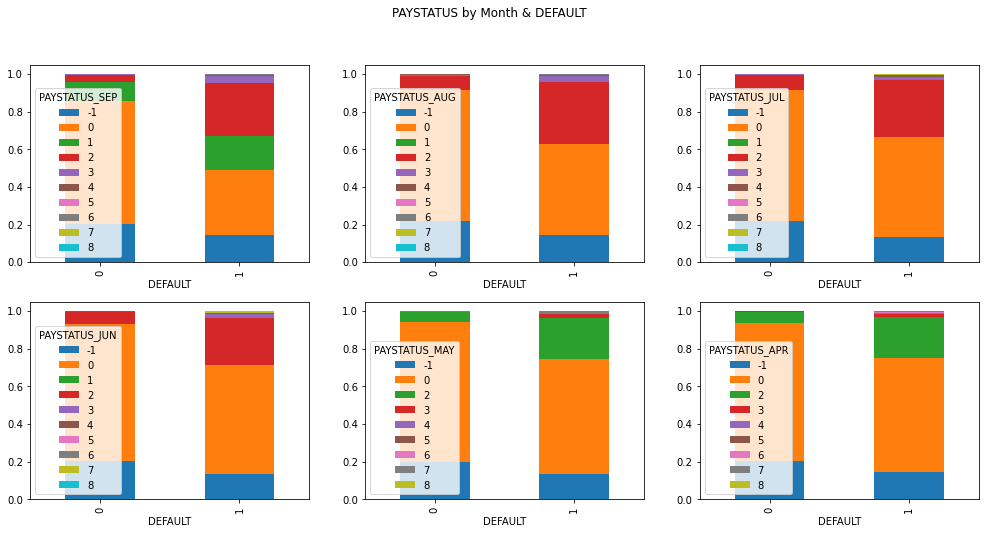

In [32]:
month_default = ['SEP DEFAULT', 'AUG DEFAULT', 'JUL DEFAULT', 'JUN DEFAULT', 'MAY DEFAULT', 'APR DEFAULT']
fig, ax = plt.subplots(2, 3, figsize=(17,8))
plt.suptitle('PAYSTATUS by Month & DEFAULT')
df.groupby('DEFAULT')['PAYSTATUS_SEP'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax[0,0])
df.groupby('DEFAULT')['PAYSTATUS_AUG'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax[0,1])
df.groupby('DEFAULT')['PAYSTATUS_JUL'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax[0,2])
df.groupby('DEFAULT')['PAYSTATUS_JUN'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax[1,0])
df.groupby('DEFAULT')['PAYSTATUS_MAY'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax[1,1])
df.groupby('DEFAULT')['PAYSTATUS_APR'].value_counts(normalize = True).unstack().plot(kind='bar', stacked = True, ax = ax[1,2]);

From these graphs we can see which PayStatus categories the DEFAULTERS fall in this data. The majority of these values are the lower numbers meaning revolving credit, pay duly, delaying for 1-2 months. The upper values shown in the legend are present, but don't seem to influence results due to their relatively low percentages. From the looks of this, I think paystatus will be significant in DEFAULT detection.